<a href="https://colab.research.google.com/github/IAI-UNSAM/ML_UNSAM/blob/main/19_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras

#tensorboard
%load_ext tensorboard
import datetime, os 

# AutoEncoders

## El AE más simple

El AE es una ANN cuyas capas de input y output tienen la misma cantidad de neuronas: los features. Además, existe una capa oculta de dimensión menor que cumple el rol de dimensión latente. El entrenamiento es no supervisado(o más bien autosupervisado): la red busca aprender a reproducir el input. 

Reproducir el input implica que el algoritmo aprendió a codificar los datos en una representación latente (encoder) y decodificar esta representación latente y obtener los features (decoder). El objetivo es lograr esto con una pérdida mínima de información.

El AE más simple tiene una única capa oculta. Utilicemos este AE para codificar el dataset de MNIST a un vector de dimensión 32.

In [ ]:
keras.backend.clear_session()

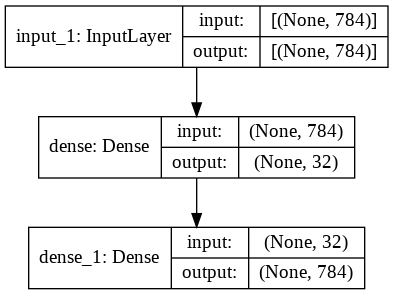

In [ ]:
# Definimos la dimensionalidad de nuestro espacio latente
encoding_dim = 32  # 32 floats -> factor de compresión 784/32 =  24.5

#input placeholder
input_img = keras.layers.Input(shape=(784,)) 

#codings
encoded = keras.layers.Dense(encoding_dim, activation='relu')(input_img)

#output: We use a sigmoid function to ensure that the output pixels are between 0 and 1
decoded = keras.layers.Dense(784, activation='sigmoid')(encoded)

#The model is instantiated as:
autoencoder = keras.models.Model(input_img, decoded)

keras.utils.plot_model(autoencoder, show_shapes=True)

Este modelo tiene dos subredes.

El encoder:

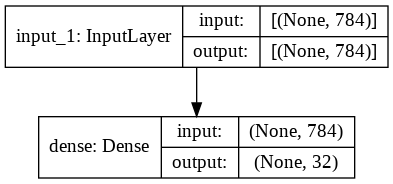

In [ ]:
encoder = keras.models.Model(input_img, encoded)
keras.utils.plot_model(encoder, show_shapes=True)

Y el decoder:

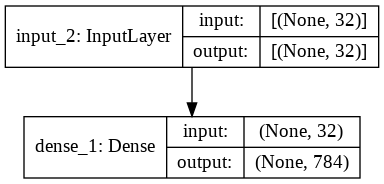

In [ ]:
# Necesitamos un input auxiliar de placehoder

encoded_input = keras.layers.Input(shape=(encoding_dim,))

#Obtenemos la última capa del autoencoder. En este caso, es el decoder
decoder_layer = autoencoder.layers[-1]

# Instanciamos el nuevo modelo aplicando el decoder al nuevo input
decoder = keras.models.Model(encoded_input, decoder_layer(encoded_input))

keras.utils.plot_model(decoder, show_shapes=True)

Antes de compilar, necesitamos definir la función de pérdida. Podríamos tratar esto como un problema de regresión pixel a pixel. Sin embargo, como tenemos 784 números entre 0 y 1, combiene pensar que tenemos 784 problemas binarios de clasificación y utilizar entropía cruzada.

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Veamos como funciona en MNIST:

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#normalizamos a [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
#Y pasamos a un vector de dimensión 784
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


Entrenamos:

In [ ]:
#tensorboard initialization
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
%tensorboard --logdir logs

In [ ]:
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test),
                          callbacks=[tensorboard_callback]
                         )

Epoch 1/50
235/235 [==============================] - 3s 11ms/step - loss: 0.2774 - val_loss: 0.1894
Epoch 2/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1709 - val_loss: 0.1536
Epoch 3/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1442 - val_loss: 0.1335
Epoch 4/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1285 - val_loss: 0.1212
Epoch 5/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1182 - val_loss: 0.1128
Epoch 6/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1110 - val_loss: 0.1072
Epoch 7/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1060 - val_loss: 0.1029
Epoch 8/50
235/235 [==============================] - 2s 10ms/step - loss: 0.1023 - val_loss: 0.0996
Epoch 9/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0997 - val_loss: 0.0974
Epoch 10/50
235/235 [==============================] - 3s 11ms/step - loss: 0.0979 - val_lo

Habiendo entrenado nuestra red, podemos codificar imagenes de 28x28 y decodificarlas. Aunque entrenamos el autoencoder, por como definimos las cosas los pesos también están actualizados en el encoder y en el decoder.




In [ ]:
#encoding:
encoded_imgs = encoder.predict(x_test)
#decoding: (esto es analogo a autoencoder.predict(x_test))
decoded_imgs = decoder.predict(encoded_imgs)

Visualicemos algunas de estas imagenes

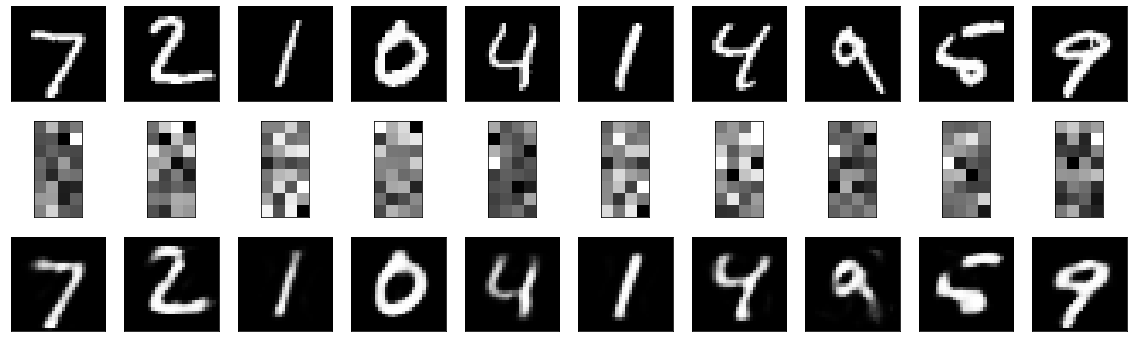

In [ ]:
n = 10  # cuantos digitos imprimimos
plt.figure(figsize=(20, 6))
for i in range(n):
    # original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # espacio latente
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstrucción
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
encoded_imgs[0]

array([ 5.928564  , 11.742851  ,  5.132927  ,  7.8214087 ,  5.1981397 ,
        5.461176  ,  0.31104112, 15.97676   ,  4.622369  ,  6.443037  ,
        5.0045023 ,  4.773183  ,  6.8645234 ,  4.528063  ,  9.878958  ,
        4.384567  ,  6.5383115 ,  2.728327  ,  7.8191414 ,  7.1963253 ,
        7.199874  , 10.135482  ,  2.1481774 ,  2.5239747 ,  9.708685  ,
        9.956411  ,  2.0323305 ,  6.2426844 ,  8.286953  , 13.236473  ,
        5.9727993 ,  5.221168  ], dtype=float32)

Para lo simple que es... No es tan malo. Eso si, interpretar el espacio latente no es trivial (ni garantiza algo...)

## Deep AE

Por supuesto, la idea se puede generalizar haciendo arquitecturas más profundas. Esto se suele llamar *Stacked AutoEncoders*. La idea es que añadir más capas permite aprender codificaciones más complejas.

En general, la arquitectura de un stacked autoencoder es simétrica con respecto a la capa oculta central (la capa codificadora). Pueden visualizar un sambuche.


![AutoEncoder from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/2/28/Autoencoder_structure.png)

**Advertencia:** Hay que ser cuidadoso y no hacer al AE demasiado poderoso. Puede pasar que el AE aprenda una codificación única para cada dato. Esto implica que la representación de los datos no es útil y que probablemente generalice pésimo.

Nuevamente, volvamos al MNIST:

In [ ]:
keras.backend.clear_session()

In [ ]:
input_img = keras.layers.Input(shape=(784,))
encoded = keras.layers.Dense(128, activation='relu')(input_img)
encoded = keras.layers.Dense(64, activation='relu')(encoded)
encoded = keras.layers.Dense(32, activation='relu')(encoded)

decoded = keras.layers.Dense(64, activation='relu')(encoded)
decoded = keras.layers.Dense(128, activation='relu')(decoded)
decoded = keras.layers.Dense(784, activation='sigmoid')(decoded)

deep_autoencoder = keras.models.Model(input_img, decoded)

deep_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

deep_autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136

Entrenemos utilizando EarlyStopping:

In [ ]:
#tensorboard initialization
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
%tensorboard --logdir logs

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

history = deep_autoencoder.fit(x_train, x_train,
                               epochs=100,
                               batch_size=256,
                               shuffle=True,
                               validation_data=(x_test, x_test),
                               callbacks=[tensorboard_callback,early_stopping_cb],
                               verbose=False)

Y veamos las imagenes resultantes

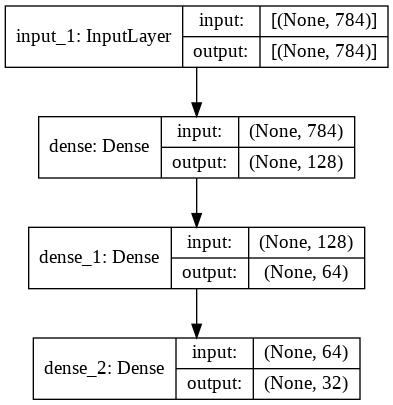

In [ ]:
encoder = keras.models.Model(input_img, encoded)
keras.utils.plot_model(encoder, show_shapes=True)

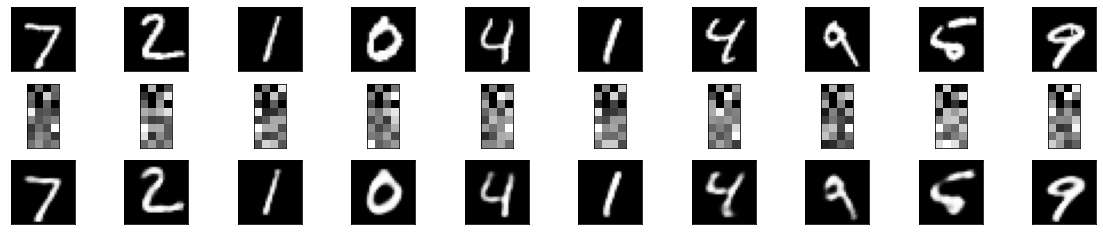

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = deep_autoencoder.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # espacio original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # espacio latente
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8, 4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # espacio reconstruido
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Convolutional AutoEncoder:

Dado que estamos lidiando con imagenes, podemos incorporar lo que aprendimos la semana pasada: capas convolucionales. La sutileza que aparece al incorporar capas convolucionales es que necesitamos regresar al tamaño original (lo que se llama _up-sampling_).

In [ ]:
keras.backend.clear_session()

In [ ]:
input_img = keras.layers.Input(shape=(28, 28, 1))

#Encoder: Conv -> MaxPool (x2)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

#La representación latente tiene shape (7, 7, 32) i.e. dimensión 128

#Decoder: Conv -> UpSampling (x3)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)# el UpSampling se ocupa de aumentar la dimensionalidad reptiendo las filas y las columnas por size[0] y size[1] respectivamente
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

conv_autoencoder = keras.models.Model(input_img, decoded)
conv_autoencoder.compile(loss='binary_crossentropy')

Volvemos a importar el dataset para preservar las dimensiones

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#normalizamos los pixeles [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

hist = conv_autoencoder.fit(x_train, x_train,
                            epochs=100,
                            batch_size=128,
                            shuffle=True,
                            validation_data=(x_test, x_test),
                            callbacks=[early_stopping_cb, tensorboard_callback])

Epoch 1/100
469/469 [==============================] - 34s 11ms/step - loss: 0.1183 - val_loss: 0.0825
Epoch 2/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0798 - val_loss: 0.0798
Epoch 3/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0750 - val_loss: 0.0741
Epoch 4/100
469/469 [==============================] - 4s 9ms/step - loss: 0.0728 - val_loss: 0.0713
Epoch 5/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0714 - val_loss: 0.0713
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0705 - val_loss: 0.0702
Epoch 7/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0697 - val_loss: 0.0685
Epoch 8/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0692 - val_loss: 0.0686
Epoch 9/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0687 - val_loss: 0.0684
Epoch 10/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0683 - val_

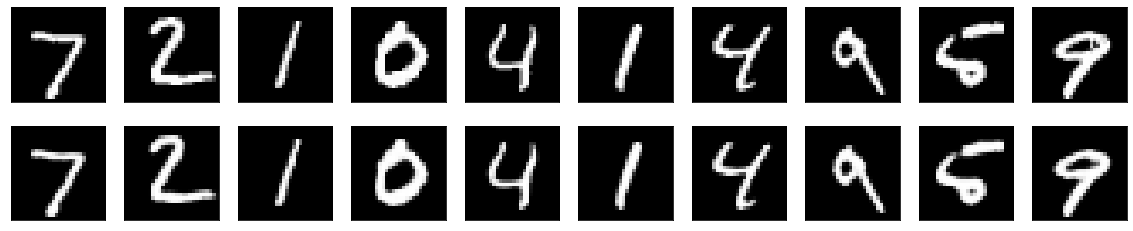

In [ ]:
decoded_imgs = conv_autoencoder.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Noise reduction

Como vimos en las diapos, una posible aplicación de los AEs es que pueden utilizar para "limpiar" los datos. Cualquier ruido que no siga los patrones del conjunto de entrenamiento será "limpiado" al pasar a través del AE. Veamoslo con nuestro AE convolucional agregando un poco de ruido.

In [ ]:
#Agregamos ruido gaussiano a nuestras imagenes
noise_factor = 0.2
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

#Nos aseguramos de que los pixeles estén en el rango [0,1] utilizando saturación.
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Estas son las imagenes ruidosas:

Original


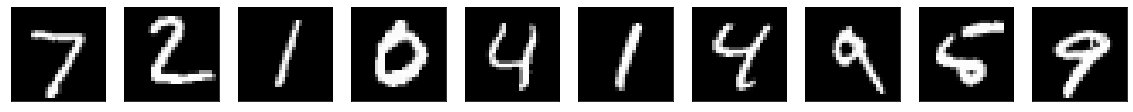

Ruidosa


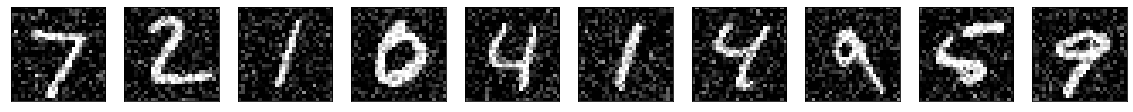

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
print("Original")
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
print("Ruidosa")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Y veamos como las limpia el AE:

In [ ]:
x_test_cleaned = conv_autoencoder.predict(x_test_noisy)

Original


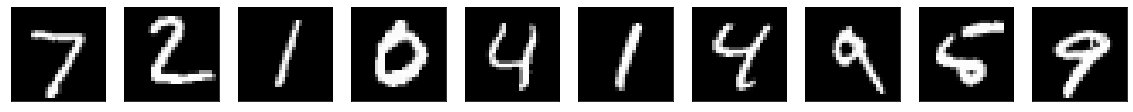

Ruidosa


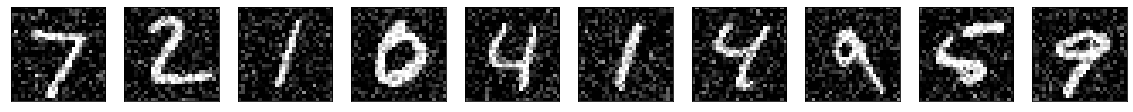

Limpia


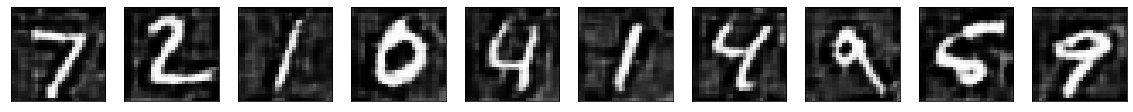

In [ ]:
n = 10

print("Original")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Ruidosa")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 2))
print("Limpia")
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_cleaned[i].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Podemos aplicar el AE muchas veces para tratar de sacar más ruido. Sin embargo, esto puede magnificar cualquier distorsión que tenga el AE.

Limpia


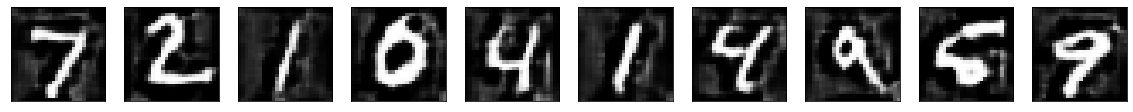

In [ ]:
#Iteremos
x_test_cleaned = conv_autoencoder.predict(x_test_cleaned)

#Visualicemos
plt.figure(figsize=(20, 2))
print("Limpia")
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_cleaned[i].squeeze())
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Denoising AutoEncoders:

Sin embargo, si lo que nos interesa es quitar el ruido conviene entrenar un AE para ese rol. Esta idea (que existe desde hace bastante tiempo) consiste en agregar ruido a los datos de entrenamiento y entrenar la AE para recuperar la imagen "limpia". 

El ruido puede agregarse como ruido normal o puede implementarse añadiendo una capa de Dropout que apague algunos pixeles (que pueden jugar el rol de, por ejemplo, pixeles muertos en una CCD).

Veamos:

In [ ]:
keras.backend.clear_session()

dropout_encoder = keras.models.Sequential([
    keras.layers.Dropout(0.2, input_shape=(28,28,1)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2), padding='same'),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2), padding='same')
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.UpSampling2D((2, 2)),
    keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

dropout_autoencoder = keras.models.Sequential([dropout_encoder, dropout_decoder])

dropout_autoencoder.compile(loss='binary_crossentropy')

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

hist = dropout_autoencoder.fit(x_train, x_train,
                            epochs=100,
                            batch_size=128,
                            shuffle=True,
                            validation_data=(x_test, x_test),
                            callbacks=[early_stopping_cb, tensorboard_callback])

Epoch 1/100
469/469 [==============================] - 6s 10ms/step - loss: 0.1200 - val_loss: 0.0857
Epoch 2/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0848 - val_loss: 0.0838
Epoch 3/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0800 - val_loss: 0.0789
Epoch 4/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0776 - val_loss: 0.0771
Epoch 5/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0761 - val_loss: 0.0768
Epoch 6/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0751 - val_loss: 0.0736
Epoch 7/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0743 - val_loss: 0.0740
Epoch 8/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0736 - val_loss: 0.0787
Epoch 9/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0731 - val_loss: 0.0723
Epoch 10/100
469/469 [==============================] - 4s 8ms/step - loss: 0.0727 - val_l

Veamos como funciona y comparemos con el AE anterior

In [ ]:
x_test_cleaned_do = dropout_autoencoder.predict(x_test_noisy)

Original


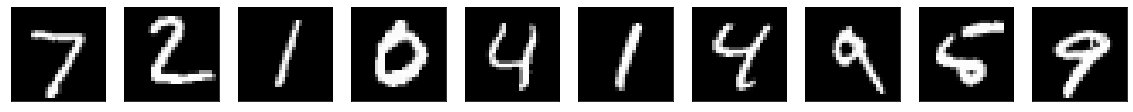

Ruidosa


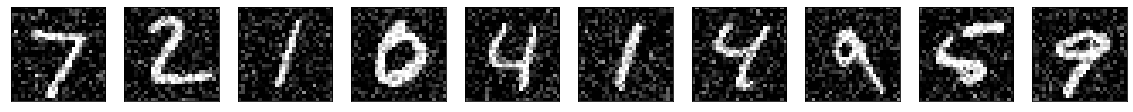

Limpia (sin DropOut)


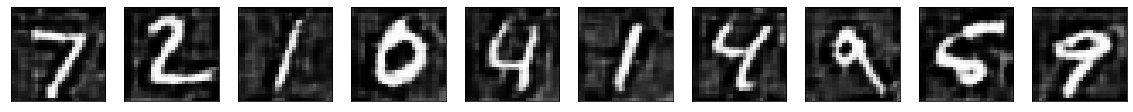

Limpia (con DropOut)


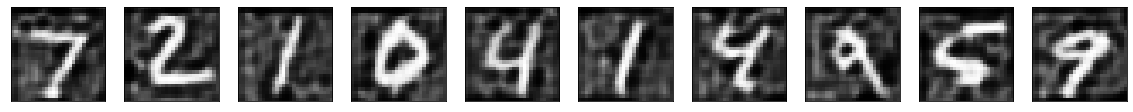

In [ ]:
n = 10

print("Original")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

print("Ruidosa")
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 2))
print("Limpia (sin DropOut)")
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_cleaned[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(20, 2))
print("Limpia (con DropOut)")
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_cleaned_do[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

También podemos comparar las pérdidas de ambos AEs:

In [ ]:
dropout_autoencoder.evaluate(x_test, x_test_noisy)

313/313 [==============================] - 1s 3ms/step - loss: 0.9534


0.9534109234809875

In [ ]:
conv_autoencoder.evaluate(x_test, x_test_noisy)

313/313 [==============================] - 1s 3ms/step - loss: 1.0218


1.0218017101287842

## Sparse AutoEncoders

Una manera de mejorar la performance de los AEs es forzar a que la codificación sea _esparza_: es decir, que se activen pocas neuronas en la capa de codificación para cada input.  La idea es que cada neurona de la capa termine siendo útil por si misma.

Una manera "sencilla" de hacer esto es tomar una capa de codificación grande (por ejemplo 300 unidades) con activación sigmoide  (para que los valores estén entre 0 y 1) y agregar una regularización $\ell_{1}$ que se sume al output de la capa.

Probemos como hacer esto

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

#normalizamos los pixeles [0,1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

Definamos un benchmark para comparar:

In [16]:
keras.backend.clear_session()

In [17]:
simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=['accuracy'])
history = simple_ae.fit(x_train, x_train, epochs=10,
                        validation_data=(x_test, x_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2679 - accuracy: 0.0697 - val_loss: 0.2470 - val_accuracy: 0.0836
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2356 - accuracy: 0.0947 - val_loss: 0.2172 - val_accuracy: 0.1158
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2038 - accuracy: 0.1328 - val_loss: 0.1905 - val_accuracy: 0.1501
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1824 - accuracy: 0.1583 - val_loss: 0.1741 - val_accuracy: 0.1664
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1701 - accuracy: 0.1723 - val_loss: 0.1644 - val_accuracy: 0.1765
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1629 - accuracy: 0.1821 - val_loss: 0.1583 - val_accuracy: 0.1858
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1558 - accuracy: 0.1943 - val_loss: 0.1504 - val_accuracy:

Y el modelo regularizado

In [14]:
keras.backend.clear_session()

In [15]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternativamente, se puede utilizar activity_regularizer=keras.regularizers.l1(1e-3) en la capa previa
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=['accuracy'])
history = sparse_l1_ae.fit(x_train, x_train, epochs=10,
                           validation_data=(x_test, x_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2803 - accuracy: 0.0757 - val_loss: 0.2532 - val_accuracy: 0.0835
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2480 - accuracy: 0.0890 - val_loss: 0.2417 - val_accuracy: 0.0955
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2345 - accuracy: 0.1045 - val_loss: 0.2243 - val_accuracy: 0.1120
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2203 - accuracy: 0.1175 - val_loss: 0.2141 - val_accuracy: 0.1253
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2105 - accuracy: 0.1316 - val_loss: 0.2015 - val_accuracy: 0.1437
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1956 - accuracy: 0.1506 - val_loss: 0.1897 - val_accuracy: 0.1570
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1880 - accuracy: 0.1590 - val_loss: 0.1838 - val_accuracy:

Veamos la diferencia entre ambos robando algunas funciones a Geron

In [29]:
import matplotlib as mpl
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram(encoder, height=1, n_bins=10):
    x_test_codings = encoder(x_test).numpy()
    activation_means = x_test_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, x_test_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Media Global = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activación")
    ax1.set_ylabel("% Activaciones")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Activación media de unidad")
    ax2.set_ylabel("% Unidades")
    ax2.axis([0, 1, 0, height])

El primer gráfico cuenta, para los datos de testeo, el promedio de las 30 activaciones para cada dato. El segundo, analiza unidad por unidad y cuanta para cada unidad la activación promedio.

Sin regularizar


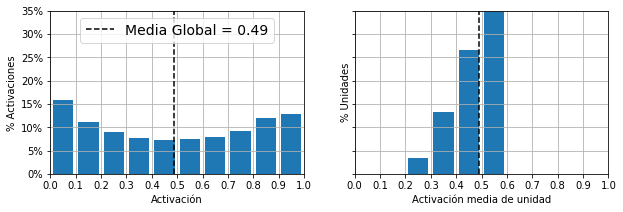

Regularizando L1


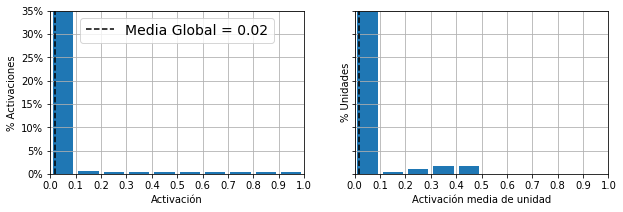

In [36]:
print('Sin regularizar')
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

print('Regularizando L1')
plot_activations_histogram(sparse_l1_encoder, height=0.35)
plt.show()

Suceden dos cosas al regularizar:
- En el gráfico de la izquierda, se ve que para cada dato la activación tiende a ser más chica.
- En el gráfico de la derecha, se ve que cada unidad se activa menos.

En efecto, parece que tenemos unidades menos activadas y que se activan menos al mismo tiempo.

Otra manera de controlar esto, y que suele funcionar mejor, es elegir una _sparsity_ y penalizar desviaciones de esa _sparsity_. Para eso, promediamos la activación de cada unidad para cada _batch_ de entrenamiento (que tendrá que ser lo suficientemente grande). Una vez que tenemos esta lista, penalizamos aquellas neuronas que se activen demasiado (o demasiado poco). Hacemos esto agregando una _sparsity loss_.

La _sparsity loss_ podría ser una MSE entre los valores $q_{i}$ medidos para cada unidad y el objetivo $p$. Sin embargo, conviene utilizar la divergencia de Kullback-Leiblner (que aparece en VAEs tambien pero por otras razones). Esto sucede porque los gradientes son mayores y es más rápido el entrenamiento.

Para este caso super sencillo, la _sparsity loss_ queda

$$\text{KL }(p||q)=\sum_{i}p\text{Ln }\frac{p}{q_{i}}+(1-p)\text{Ln }\frac{1-p}{1-q_{i}}$$

donde $p$ es el _sparsity_ deseado.

Para combinar esta perdida con la perdida de reconstrucción, necesitamos introducir otro hiperparametro: el peso relativo entre pérdidas.

Podemos implementar la función de pérdida de la siguiente manera:

In [31]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

Esta clase, asumiendo un target de 0.1, calcula la KL para una unidad. Es lo mismo que hace la regularización $\ell_{1}$ pero tomando otro criterio.

In [32]:
keras.backend.clear_session()

In [33]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=['accuracy'])
history = sparse_kl_ae.fit(x_train, x_train, epochs=10,
                           validation_data=(x_test, x_test))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2630 - accuracy: 0.0876 - val_loss: 0.2395 - val_accuracy: 0.1054
Epoch 2/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.2219 - accuracy: 0.1198 - val_loss: 0.2021 - val_accuracy: 0.1464
Epoch 3/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1871 - accuracy: 0.1593 - val_loss: 0.1785 - val_accuracy: 0.1677
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1694 - accuracy: 0.1784 - val_loss: 0.1643 - val_accuracy: 0.1862
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1575 - accuracy: 0.1967 - val_loss: 0.1549 - val_accuracy: 0.1988
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1496 - accuracy: 0.2073 - val_loss: 0.1481 - val_accuracy: 0.2081
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1431 - accuracy: 0.2147 - val_loss: 0.1417 - val_accuracy:

Sin regularizar


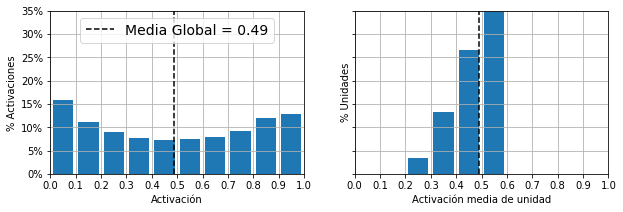

Regularizando L1


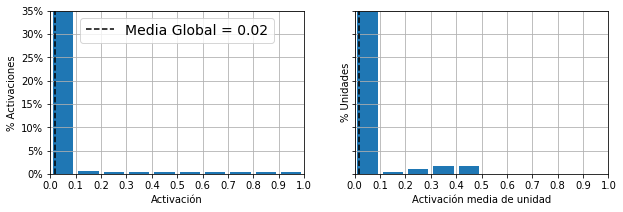

Regularizando KL


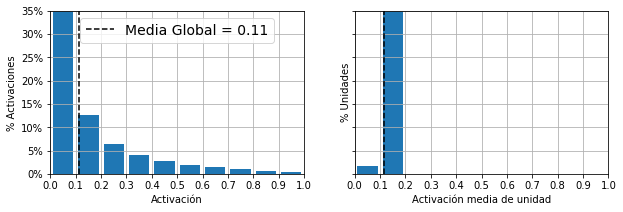

In [34]:
print('Sin regularizar')
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

print('Regularizando L1')
plot_activations_histogram(sparse_l1_encoder, height=0.35)
plt.show()

print('Regularizando KL')
plot_activations_histogram(sparse_kl_encoder, height=0.35)
plt.show()


Esta un poco más repartido la activación por medición y la activación media por unidad busca estar cerca del target. 

## Variational AutoEncoder (VAE)

Una categoría importante de AutoEncoders fue introducida en este [trabajo del 2013](https://arxiv.org/abs/1312.6114) y rápidamente se convirtió en una de las variantes más populares de AEs: el AutoEncoder Variacional.

Los VAEs difieren de los AEs en las siguientes tres características:
- Son _AutoEncoders_ probabilísticos: Los outputs son parcialmente determinados por el azar incluso en la etapa de inferencia (en los denoising AEs la limpieza era determinista).
- Son _AutoEncoders generativos_: Pueden generar nuevas instancias de datos que parecen haber sido sampleados del dataset de entrenamiento.
- Pueden ser entrenados para realizar Inferencia Bayesiana Variacional, una manera veloz de realizar inferencia Bayesiana aproximada.

La idea es la siguiente: en vez de mapear instancias de entrenamiento a un vector latente de baja dimensionalidad que a su vez es mapeado de manera _determinista_ de vuelta al espacio original, vamos a mapear las instancias de entrenamiento a distribuciones de probabilidad de codeos. El decoder toma estas distribuciones y genera los datos.

Por ejemplo, en lugar de aprender una _codificación_ para un dado input, el encoder aprende una _media de codificación_ $\mu$ y una _desviación estándar de codificación_ \sigma. La codificación se samplea al azar de una distribución normal con media $\mu$ y desviación estándar $\sigma$. Tras samplear, el decoder decodifica como antes.

Construyamos este ejemplo. Vamos a necesitar guardar las dimensiones de las instancias de entrenamiento.

In [ ]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# useful variables
image_size = x_train.shape[1]

original_dim = image_size * image_size

# Normalization
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Ahora definamos los parametros de la red. Vamos a utilizar dos codificadores dos-dimensionales (en total, cuatro) y aprenderemos una distribución bi-normal para nuestra codificación.

In [ ]:
keras.backend.clear_session()

# network parameters
input_shape = (image_size, image_size, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

### Sampling Layer

Para implementar el VAE con sampleo gaussiano, necesitamos **definir** una capa de Keras que samplee de dos gaussianas. Esto, que no viene incluido en la librería Keras, es fácilmente definible:

In [ ]:
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

Esta capa toma dos inputs: las medias $\mu$ de las distribuciones y los logaritmos de las varianzas $\log \sigma^2$. Esto último se suele hacer ya que es númericamente más estable que aprender $\sigma$ o $\sigma^2$.

### Encoder:

Tras definir la capa de sampleo, podemos construir nuestro encoder. Como el modelo no es enteramente secuencial, necesitamos utilizar la API funcional.

Model: "variational_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           encoder_input[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      flatten[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense[0][0]                      
________________________________________________________________________________

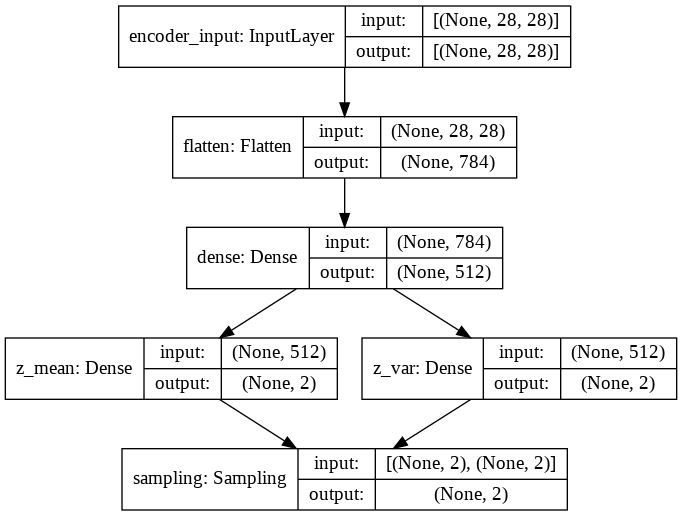

In [ ]:

inputs = keras.layers.Input(shape=input_shape, name='encoder_input')
x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(intermediate_dim, activation='relu')(x)
z_mean = keras.layers.Dense(latent_dim, name='z_mean')(x)
z_logvar = keras.layers.Dense(latent_dim, name='z_var')(x)
z = Sampling()([z_mean, z_logvar])


variational_encoder = keras.models.Model(inputs = [inputs], 
                                         outputs=[z_mean, z_logvar, z],
                                         name='variational_encoder')
variational_encoder.summary()
keras.utils.plot_model(variational_encoder, show_shapes=True)

### Decoder

El decoder es todavia más simple: es lo mismo que en el caso del AE. El input es la codificación sampleada al final del encoder.

Model: "variational_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               402192    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


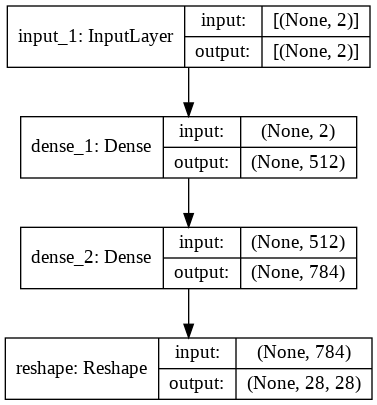

In [ ]:
# Variational decoder
latent_inputs = keras.layers.Input(shape=(latent_dim,))
x = keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
# Uso una función sigmoide para la activación de la última capa para asegurarme de tener pixeles en [0,1]
x = keras.layers.Dense(original_dim, activation='sigmoid')(x)
outputs = keras.layers.Reshape(input_shape)(x)

# instanceo el modelo del decoder
variational_decoder = keras.models.Model(inputs=[latent_inputs], outputs=[outputs], name='variational_decoder')
variational_decoder.summary()
keras.utils.plot_model(variational_decoder, show_shapes=True)

### Full model

Para terminar, armamos el AutoEncoder juntando las dos piezas:

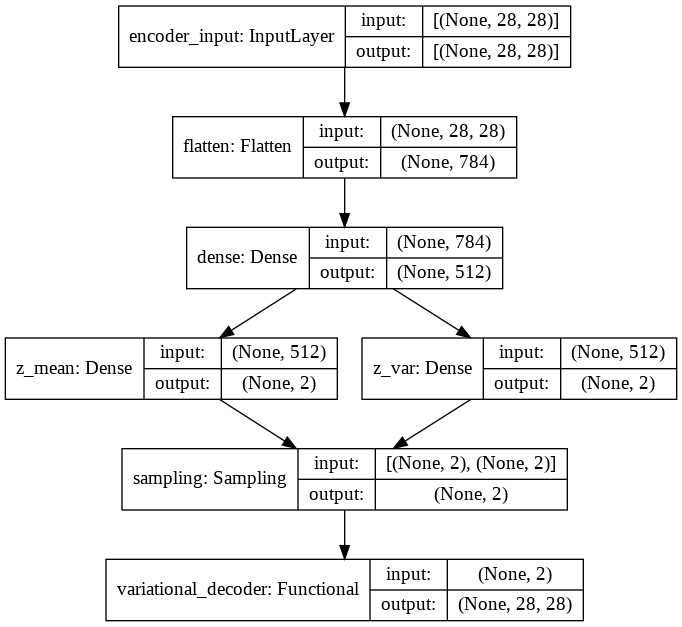

In [ ]:
#el decoder es el modelo
#z es la variable definida como el tercer output del encoder
outputs = variational_decoder(z)

#autoencoder:
vae = keras.models.Model(inputs, outputs, name='vae_mlp')
keras.utils.plot_model(vae, show_shapes=True)

### Compilation and Training

A diferencia de los AEs anteriores, queremos forzar al AutoEncoder a aprender codificaciones distribuidas normalmente. Para asegurarnos de esto, añadimos una _perdida latente_ (_latent loss_) a la _perdida de reconstrucción_. Se utiliza la divergencia de Kullback-Leibler entre la distribución normal que buscamos y la distribución de las codificaciones. La divergencia KL mide el cambio de entropía entre distribuciones (no es una distancia pero cumple condiciones bastante lindas). Es por esta pérdida que hablamos del VAE como capaz de hacer inferencia bayesiana.

Para nuestro caso, tenemos:

$$\text{KL }=-\frac{1}{2}\sum_{i=1}^{K}(1+\text{Ln }\sigma^{2}_{i}-\sigma^{2}_{i}-\mu^{2}_{i})$$

donde $K$ es la dimensionalidad de nuestra codificación. Utilizando $\gamma=\text{Ln }\sigma^{2}$

$$\text{KL }=-\frac{1}{2}\sum_{i=1}^{K}(1+\gamma_{i}-\text{exp }\gamma_{i}-\mu^{2}_{i})$$

Esta función de pérdida se agrega con un peso relativo a la pérdida de reconstrucción. En nuestro caso, la dividimos por 784 para que estén en pie de igualdad.


In [ ]:
latent_loss = -0.5 * K.sum(
    1 + z_logvar - K.exp(z_logvar) - K.square(z_mean),
    axis=-1)

vae.add_loss(K.mean(latent_loss) / image_size**2 ) #agregamos la función de perdida latente
vae.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [ ]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

hist = vae.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks = [early_stopping_cb, tensorboard_callback])

Epoch 1/50
469/469 [==============================] - 4s 8ms/step - loss: 0.2427 - val_loss: 0.2190
Epoch 2/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2163 - val_loss: 0.2119
Epoch 3/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2099 - val_loss: 0.2074
Epoch 4/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2062 - val_loss: 0.2049
Epoch 5/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2040 - val_loss: 0.2038
Epoch 6/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2023 - val_loss: 0.2025
Epoch 7/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2011 - val_loss: 0.2007
Epoch 8/50
469/469 [==============================] - 3s 6ms/step - loss: 0.2000 - val_loss: 0.2004
Epoch 9/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1991 - val_loss: 0.1991
Epoch 10/50
469/469 [==============================] - 3s 6ms/step - loss: 0.1983 - val_loss: 0.1985

### Visualización:

Grafiquemos las reconstrucciones!

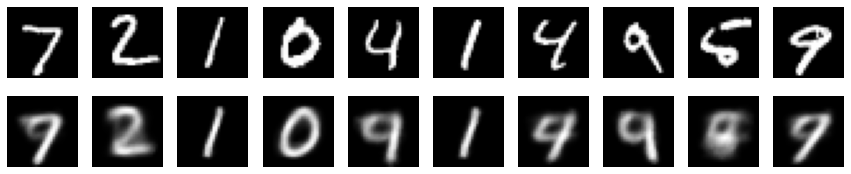

In [ ]:
def plot_image(image):
    plt.imshow(image)
    plt.axis("off")
    
def show_reconstructions(model, images=x_test, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
show_reconstructions(vae, n_images=10)

Y veamos las codificaciones en el conjunto de testeo

In [ ]:
z_mean, z_var, z = variational_encoder.predict(x_test, batch_size=batch_size)

Dado que las codificaciones son 2-dimensionales, podemos graficar su distribución. Grafiquemos únicamente las medias de las gaussianas para cada número.

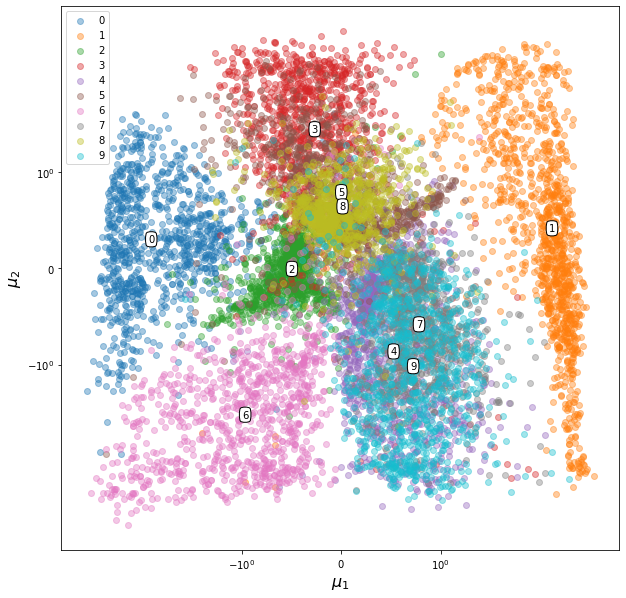

In [ ]:
#Visualizacion
plt.figure(figsize=(10, 10))

for number in range(10):
    i = y_test == number # selecciono instancias del numero number
    plt.scatter(z_mean[i, 0], z_mean[i, 1], c='C'+str(number), cmap='rainbow', label=number,
                alpha=0.4) #grafico las medias para cada una de esas instancias
    plt.annotate(str(number), (z_mean[i, 0].mean(), z_mean[i, 1].mean()), 
                 bbox=dict(boxstyle="round4", fc="w", ec="k", lw=1))#les anotamos el número encima

# plt.colorbar()
plt.xscale('symlog')
plt.yscale('symlog')

# etiquetas
plt.xlabel('$\mu_1$', fontsize=16)
plt.ylabel('$\mu_2$', fontsize=16)
plt.legend()
plt.show()

¡El espacio latente es mucho más interpretable que antes!

#### Generación de imagenes

Podemos utilizar el decodificador para generar imagenes nuevas. ¿Cómo? Pues sampleando. Sampleando codificaciones $z$ en la región de interes.

Por ejemplo, veamos una región donde los números se superponen:

In [ ]:
# mostramos una grilla 2D de digitos
n = 21  # vamos a considerar 21x21 digitos
figure = np.zeros((image_size * n, image_size * n))

# Grilla linear y simétrica en el centro: 21 números en la región [-1,1]x[-1,1]
grid_x = np.linspace(-1, 1, n)
grid_y = grid_x.copy()


for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        #sampleo la codificación / encoding
        z_sample = np.array([[xi, yi]])
        # se la doy al decoder
        x_decoded = variational_decoder.predict(z_sample)
        # Obtengo el digito y lo agrego a la figura
        digit = x_decoded
        figure[i * image_size: (i + 1) * image_size,
               j * image_size: (j + 1) * image_size] = digit

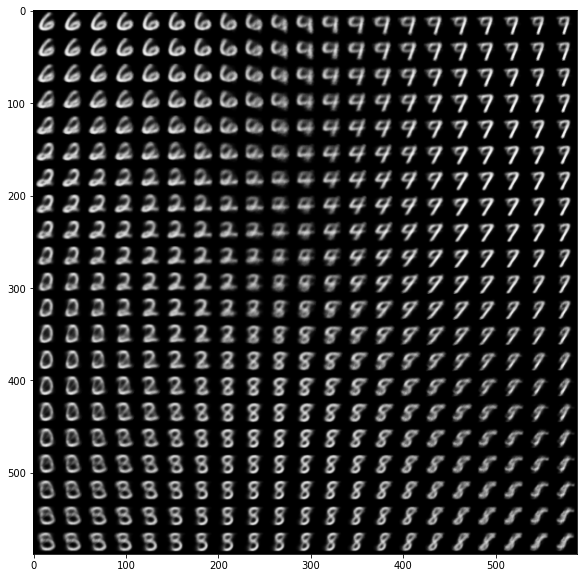

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

También podemos obtener las medias y desviaciones estándar que definen la bi-normal de una medición y samplear codificaciones / encodings con ellas. Esto generará imagenes similares pero no identicas y es muy útil para obtener datos sintéticos.

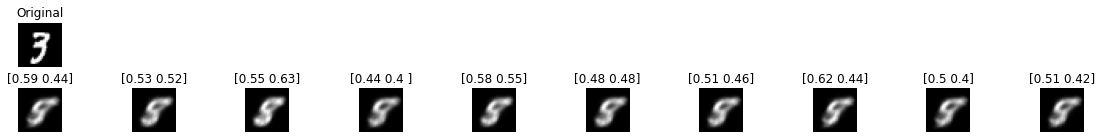

In [ ]:
# Elijo número
number = 3 # 3
n_samples = 10

# Elijo una medición al azar de ese número.
i = np.arange(x_test.shape[0])
ind = y_test == number
i_number = i[ind]
np.random.shuffle(i_number)

fig = plt.figure(figsize=(2*n_samples, 2))
ax0 = fig.add_subplot(2, n_samples, 1)

plt.subplots_adjust(hspace=0.5)

plot_image(x_test[i_number[0]])
ax0.set_title("Original")

for n_sample in range(n_samples):
    #sampleo
    zs = z_mean[i_number[0]] + np.sqrt(np.exp(z_var[i_number[0]])) * np.random.randn(2)
    #genero
    generated_im = variational_decoder.predict(zs.reshape(1,-1))
    #grafico
    ax = fig.add_subplot(2, n_samples, n_samples + n_sample + 1)
    plot_image(generated_im.squeeze())
    ax.set_title(str(np.round(zs, 2)))

plt.show()

# Your turn!

AutoEncoders are specifically designed to compress without loss of information, data that follows the distribution of the training set. Do the following experiments:
1. **What would happen if you feed an image from a different distribution?** 
* Try feeding an image from a different dataset (e.g. fashion_mnist) to one of the AEs we previously trained on the mnist dataset. 
* Plot the output, and compare the differences
* Compute the MSE on the image. How does it compare to the MSE on the mnist test set?

2. **Could you use an AE to detect outliers?**
* Use the MSE on the test set to define a threshold for the admitted loss
* Use the reconstruction MSE to flag outlier images. Try mixing images from a different dataset. 
* What accuracy does the AE have (on distinguishing outliers from a different dataset)?